## Introduction

This dataset contains information on the levels of nitrogen, phosphorus, and potassium in soil, as well as temperature, humidity, pH, and rainfall, and their impact on the growth of crops. The data can be used to make data-driven recommendations for achieving optimal nutrient and environmental conditions to improve crop yield.

## Import libraries

In [17]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
%matplotlib notebook
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
df = pd.read_csv('/kaggle/input/crop-recommendation/Crop_recommendation.csv') 
df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,Unnamed: 8,Unnamed: 9
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,NaN,NaN
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,NaN,NaN
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,NaN,NaN
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,NaN,NaN
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,NaN,NaN


In [19]:
df = df.drop(columns=['Unnamed: 8', 'Unnamed: 9'])

In [20]:
df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [21]:
df.isnull().sum()

Nitrogen       0
phosphorus     0
potassium      0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

## EDA

In [22]:
df.describe(include='all')

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rice
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655,NaN
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389,NaN
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267,NaN
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686,NaN
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624,NaN
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508,NaN


Creating the necessary lists

In [23]:
indicators = df.columns[:-1]
ylabels = ['The amount of nitrogen (in kg/ha)', 'The amount of phosphorus (in kg/ha)', 'The amount of potassium (in kg/ha)', 'The average temperature (in Celsius)', 'Humidity (in percentage)', 'pH', 'The amount of rainfall (in mm)']
labels = df.label.unique()
N = len(labels)

In [24]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
for j in range(len(indicators)):
    fig = go.Figure()
    for i in range(N):
        fig.add_trace(go.Box(y=df[indicators[j]][df.label == labels[i]], marker_color=c[i], name=labels[i])) 
    fig.update_layout(
        title='Box plots of ' + indicators[j].lower() +  ' distibution',
        yaxis_title=ylabels[j],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(zeroline=False, gridcolor='white'),
        paper_bgcolor='rgb(233,233,233)',
        plot_bgcolor='rgb(233,233,233)',
        font=dict(size=14),
        legend=dict(yanchor="top",y=0.99, xanchor="right",x=0.99)
    )

    fig.show()

In [25]:
for i in range(len(indicators)):
    group_df = df.groupby(df.label)[indicators[i]].mean().sort_values(ascending = True).reset_index()
    fig = go.Figure()
    fig.add_trace(go.Bar(y=group_df[indicators[i]], x=group_df['label'], text=group_df[indicators[i]]))
    fig.update_traces(texttemplate='%{text:.4s}', textposition='outside')
    fig.update_layout(
        uniformtext_minsize=8, 
        uniformtext_mode='hide',
        title='Mean values of ' + indicators[i].lower() +  ' in crop for different plants',
        font=dict(size=16)
    )
    fig.show()    

Let's see how the data is evenly distributed across classes.

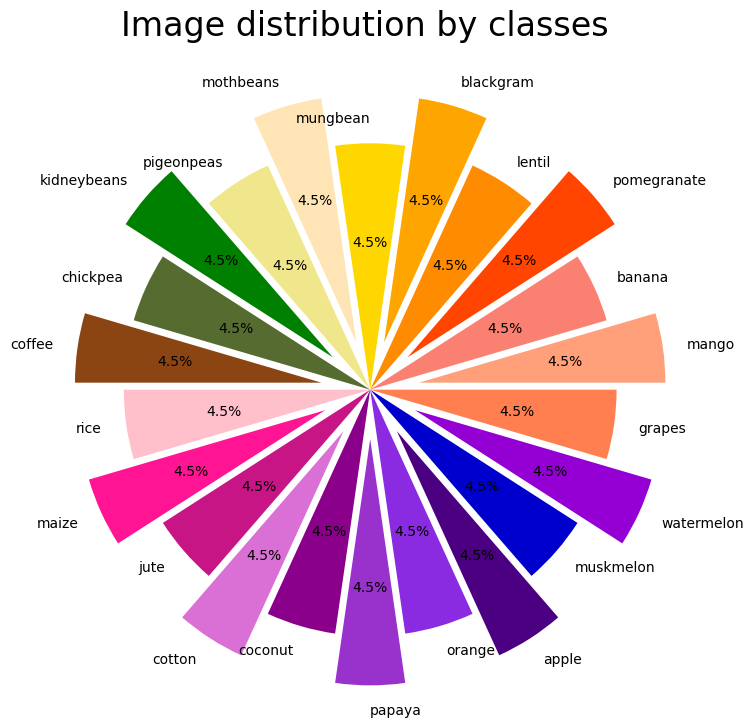

In [26]:
df_for_pie = df.label.value_counts().reset_index()
colors = ['#FFC0CB', '#FF1493', '#C71585', '#DA70D6', '#8B008B', '#9932CC', '#8A2BE2', '#4B0082', '#0000CD', '#9400D3', '#FF7F50', '#FFA07A', '#FA8072', '#FF4500', '#FF8C00', '#FFA500', '#FFD700', '#FFE4B5', '#F0E68C', '#008000', '#556B2F', '#8B4513']
explode = (0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2)
ax = plt.figure(figsize=(10,8))
plt.pie(df_for_pie['label'], labels=df_for_pie['index'], colors=colors, explode=explode, autopct='%1.1f%%', startangle=180)
plt.title('Image distribution by classes \n', size=24)
plt.show()

In [27]:
y = df['label']
X = df.drop(columns=['label'])

## Random Forest Model

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=1)

It is easy to use a GridSearch to select the ideal parameters, due to the fact that we have a small dataset, 

In [29]:
param_distribution_rand_forests = {'n_estimators': range(5, 20),  'max_depth': range(3, 30)}
model = GridSearchCV(RandomForestClassifier(), param_distribution_rand_forests, scoring='balanced_accuracy', n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 30),
                         'n_estimators': range(5, 20)},
             scoring='balanced_accuracy')

In [30]:
model.best_params_

{'max_depth': 15, 'n_estimators': 18}

In [31]:
y_pred=model.predict(X_test)

In [33]:
print ("Accuracy = ", round(accuracy_score(y_test, y_pred), 4))

Accuracy =  0.9955


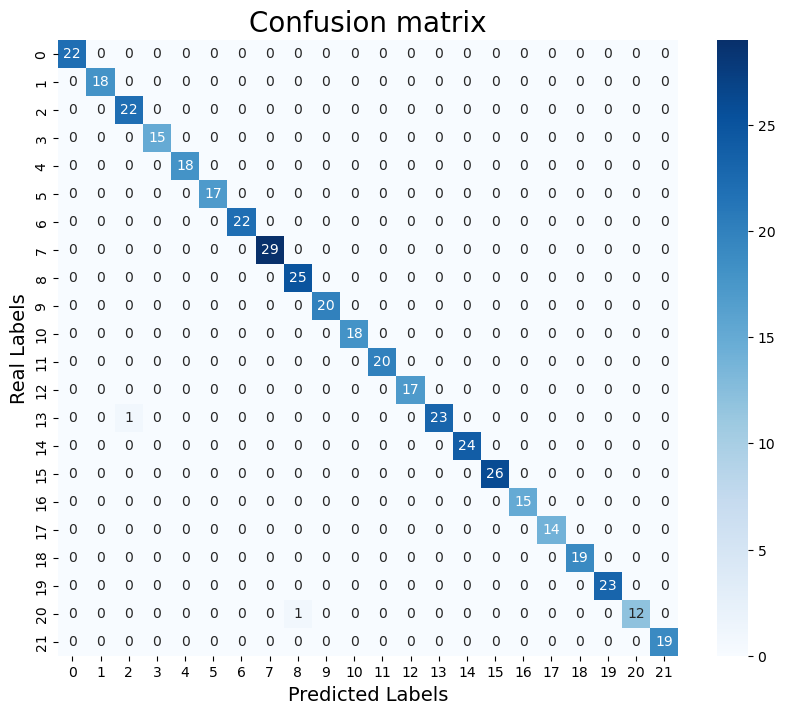

In [34]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
le.transform(y)
cm = confusion_matrix(le.transform(y_test), le.transform(y_pred))

ax = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Real Labels', size=14)
plt.show()

In [35]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

       apple     1.0000    1.0000    1.0000        22
      banana     1.0000    1.0000    1.0000        18
   blackgram     0.9565    1.0000    0.9778        22
    chickpea     1.0000    1.0000    1.0000        15
     coconut     1.0000    1.0000    1.0000        18
      coffee     1.0000    1.0000    1.0000        17
      cotton     1.0000    1.0000    1.0000        22
      grapes     1.0000    1.0000    1.0000        29
        jute     0.9615    1.0000    0.9804        25
 kidneybeans     1.0000    1.0000    1.0000        20
      lentil     1.0000    1.0000    1.0000        18
       maize     1.0000    1.0000    1.0000        20
       mango     1.0000    1.0000    1.0000        17
   mothbeans     1.0000    0.9583    0.9787        24
    mungbean     1.0000    1.0000    1.0000        24
   muskmelon     1.0000    1.0000    1.0000        26
      orange     1.0000    1.0000    1.0000        15
      papaya     1.0000    